In [1]:


import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



import matplotlib as mpl
from matplotlib import patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 
import os
from matplotlib.pyplot import imread
#ggplot
plt.style.use('classic')
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical   
import cv2
import gc
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model

import matplotlib.pyplot as plt 
from IPython.display import clear_output
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from scipy import io
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# from keras.utils import np_utils
import segmentation_models as sm
from segmentation_models import get_preprocessing, Unet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss, jaccard_loss
from segmentation_models.metrics import iou_score, f1_score
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.metrics import MeanIoU
from keras import backend as K
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler, LambdaCallback


from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import PIL
import skimage
import torchvision.transforms as T
import tensorflow_addons as tfa

Segmentation Models: using `keras` framework.


In [2]:
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)
tf.compat.v1.GPUOptions(allow_growth=True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Num GPUs Available:  1


In [3]:
IMAGE_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/Face_Segments/img'
MASK_PATH = r'/Users/joeljohnson/Desktop/Joel/Python_CG_Skin/py_skin/jan2_segmentation_FaceOnly/mask_mat'
#sort the images and masks
image_dir = sorted(os.listdir(IMAGE_PATH))
mask_dir = sorted(os.listdir(MASK_PATH))

In [4]:
factor = 0.1
def process_x(files,dsize = (256,256)):
  x = []
  for img in files:
      
      img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
      x.append(img)
    
  return np.array(x).astype("float32")     

def process_y(files,dsize = (256,256),cat = False , n_classes = 5 ):
    
    masks = []
    for img in files:
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(res)
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
    if(cat):
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        return y_train_cat
    else:
        return train_masks_input


def process_x1(files,dsize = (256,256) ):

  # files = [i for i in files] 
  
  x = []
  X = []
  for img in files:
    img = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)/255.0
    x.append(img)
  for i in x :
      image = tf.cast(tf.convert_to_tensor(i), tf.float32)
      X.append(image)
  return X 

def process_y1(files,dsize = (256,256) , cat = False , n_classes = 5 ):
    
    masks = []
    Y = []
    for img in files:
        
        res = cv2.resize(img, dsize= dsize, interpolation = cv2.INTER_NEAREST)
        masks.append(tf.convert_to_tensor(res))
    masks = np.array(masks)
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    train_masks_reshaped = masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
    if(cat == False):

        # train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        for mask in  train_masks_encoded_original_shape:
            m = tf.expand_dims(tf.convert_to_tensor(mask), axis=-1)
            m = tf.cast(m, tf.float32)
            Y.append(m)
        return Y
    else:
        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
        for mask in y_train_cat:
             m = tf.cast(tf.convert_to_tensor(mask), tf.float32)
             Y.append(m)
        return Y 
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask
    
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

def brightness(img, mask):
    img = tf.image.adjust_brightness(img, factor)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, factor)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -factor)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def rotate_n_deg(img, mask, degrees = 10):
    img = tfa.image.transform_ops.rotate(img, degrees * np.pi / 180)
    mask = tfa.image.transform_ops.rotate(mask, degrees * np.pi / 180)
    return img, mask


def further_process(X_train,y_train,X_val,y_val,BATCH = 4, augmentations = 4 ):
    
    train_X = tf.data.Dataset.from_tensor_slices(X_train)
    val_X = tf.data.Dataset.from_tensor_slices(X_val)

    train_y = tf.data.Dataset.from_tensor_slices(y_train)
    val_y = tf.data.Dataset.from_tensor_slices(y_val)

    # print(train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec)

    train = tf.data.Dataset.zip((train_X, train_y))
    train_copy = train
    val = tf.data.Dataset.zip((val_X, val_y))
    val_copy = val
    print("train length before augmentation", len(list(train.as_numpy_iterator())))
    print("val length before augmentation", len(list(val.as_numpy_iterator())))

    # perform augmentation on train data only
    for i in range(0,4):      
        if i == 0:
            factor = 0.1
            print(f"factor is {factor}")
        if i == 1:
            factor = -0.1
            print(f"factor is {factor}")
        if i == 3:
            factor = 0.3
            print(f"factor is {factor}")
        if i == 4:
            factor = -0.3
            print(f"factor is {factor}")
        if i == 5:
            break
        a1 = train.map(brightness)
        a2 = val.map(brightness)
        b1 = train.map(gamma)
        b2 = val.map(gamma)
        c1 = train.map(hue)
        c2 = val.map(hue)
        if i == 0:
            d1 = train.map(flip_vert)
            d2 = val.map(flip_vert)
        e1 = train.map(rotate)
        e2 = val.map(rotate_n_deg)

        train = train.concatenate(a1)
        train = train.concatenate(b1)
        train = train.concatenate(c1)
        val = val.concatenate(a2)
        val = val.concatenate(b2)
        val = val.concatenate(c2)
        if i == 0:
            train = train.concatenate(d1)
            val = val.concatenate(d2)
        train = train.concatenate(e1)
        val = val.concatenate(e2)
        print(f"train length after {i+1} augmentation(s)", len(list(train.as_numpy_iterator())))
        print(f"val length after {i+1} augmentation(s)", len(list(val.as_numpy_iterator())))



    STEPS_PER_EPOCH = len(list(train.as_numpy_iterator()))//BATCH
    VALIDATION_STEPS = len(list(val.as_numpy_iterator()))//BATCH
    AT = tf.data.AUTOTUNE
    BUFFER = len(X_train) + len(X_val)
    print("BUFFER " , BUFFER )

    # STEPS_PER_EPOCH = len(X_train)//BATCH
    # VALIDATION_STEPS = len(X_val)//BATCH

    # print("STEPS_PER_EPOCH " , STEPS_PER_EPOCH)
    # print("VALIDATION_STEPS " , VALIDATION_STEPS)



    train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
    train = train.prefetch(buffer_size=AT)
    val = val.batch(BATCH)
    print(f"steps per epoch {STEPS_PER_EPOCH}")
    print(f"validation steps {VALIDATION_STEPS}")

    return (train,val,STEPS_PER_EPOCH, VALIDATION_STEPS, train_X, train_y, val_X, val_y)

['.ipynb_checkpoints', '060002_4_028450_FEMALE_30.jpg', '060003_4_028451_MALE_65.jpg', '060004_4_028452_MALE_31.jpg', '060005_4_023834_FEMALE_33.jpg', '060006_4_015021_FEMALE_39.jpg', '060009_4_019350_FEMALE_21.jpg', '060012_4_020004_MALE_27.jpg', '060013_4_014380_MALE_34.jpg', '060014_4_016695_MALE_43.jpg', '060019_4_028457_MALE_33.jpg', '060020_3_024801_NONE_28.jpg', '060027_4_025986_FEMALE_36.jpg', '060028_4_022580_NONE_25.jpg', '060032_4_027166_MALE_28.jpg', '060033_4_028462_MALE_19.jpg', '060037_4_028465_FEMALE_23.jpg', '060038_4_028466_MALE_19.jpg', '060040_4_015000_FEMALE_39.jpg', '060043_4_028470_FEMALE_19.jpg', '060047_4_027403_MALE_25.jpg', 'flip.ipynb']
060002_4_028450_FEMALE_301673045657.mat
060003_4_028451_MALE_651673045658.mat
060004_4_028452_MALE_311673045647.mat
060005_4_023834_FEMALE_331673045643.mat
060006_4_015021_FEMALE_391673045638.mat
060009_4_019350_FEMALE_211673045667.mat
060012_4_020004_MALE_271673045666.mat
060013_4_014380_MALE_341673045655.mat
060014_4_016695

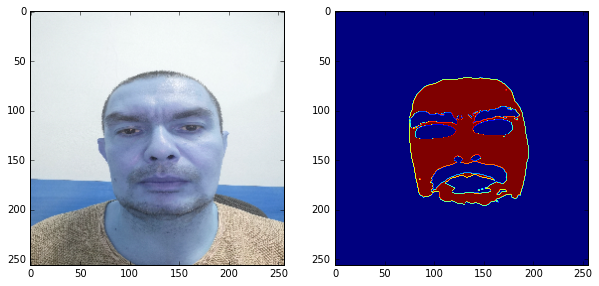

20
20


In [18]:
images =[]
images_grey = []
test_images = []
#import sorting directories
import os
from os import listdir
from os.path import isfile, join
last = 0
curr = 0
#sort images
print(image_dir)
for img in image_dir:
    if img.__contains__(".ipynb_checkpoints") or img.__contains__("flip"):
        continue
    img = cv2.imread(os.path.join(IMAGE_PATH,img))
    # img = cv2.resize(img, (256,256))/255.0
    img = cv2.resize(img, (256,256))
    
    images.append(img)
    images_grey.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
masks = []
skin_color = (212,198,169)
for mask in mask_dir:
    print(mask)
    mask = os.path.join(MASK_PATH,mask)
    file = io.loadmat(mask)
    img = file['M'].astype(np.uint8)

    #create binary mask for skin
    img = np.where(img != skin_color , (0,0,0), img)
    img = np.where(img == skin_color , (255,255,255), img)  
    img = np.asarray(img).astype(np.uint8)
    img = cv2.resize(img, (256,256))
    #convert to binary mask
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.0
    masks.append(img)



fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[1])
ax[1].imshow(masks[1])
plt.show()
print(len(images))
print(len(masks))

In [7]:
train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))

print("length: ", len(list(train)))
augmentations = []
for i in range(0,4):
    #map rotate_n_deg with argument degrees
    a = train.map(lambda x,y: rotate_n_deg(x,y, 10))

    augmentations.append(a)

train = train.concatenate(augmentations[0])
print("length: ", len(list(train)))


length:  20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
length:  40


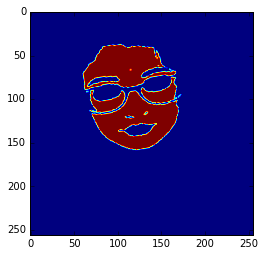

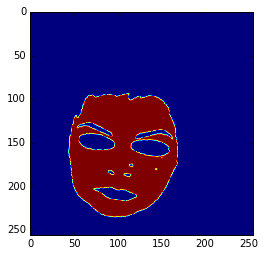

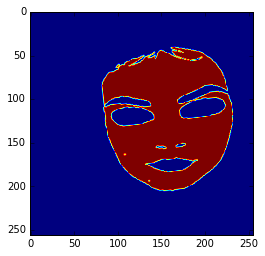

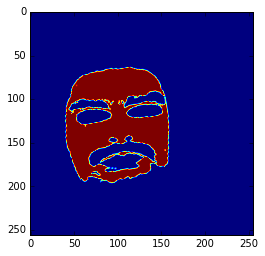

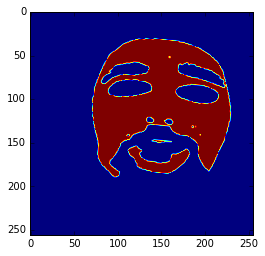

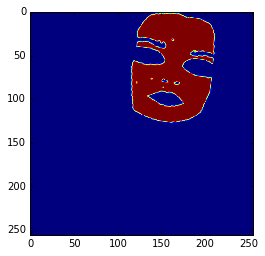

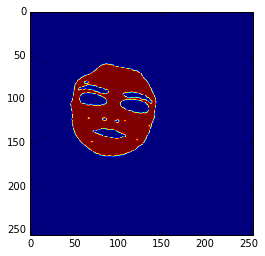

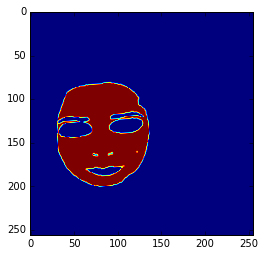

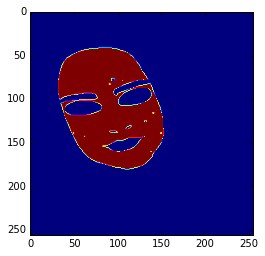

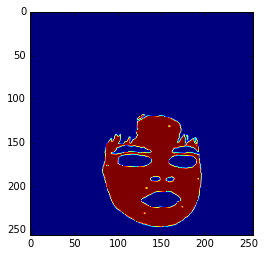

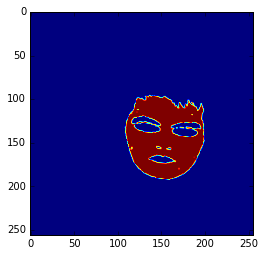

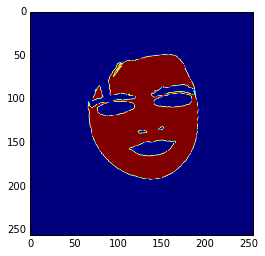

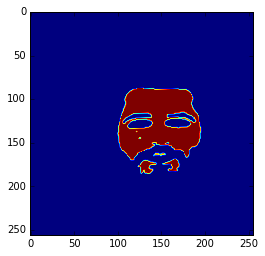

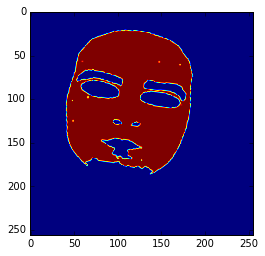

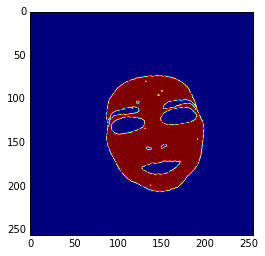

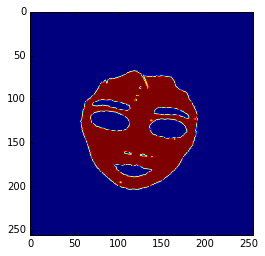

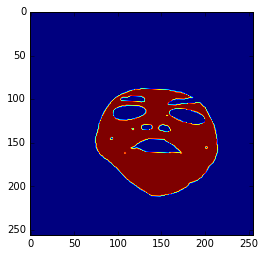

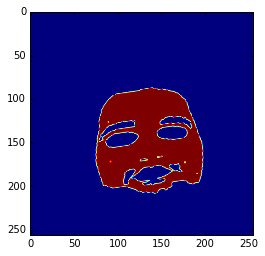

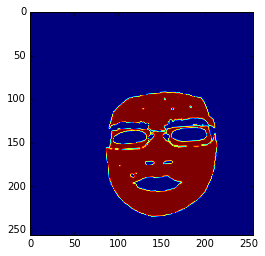

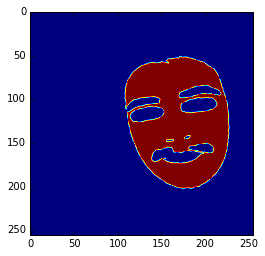

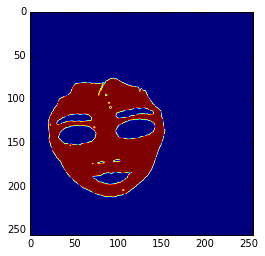

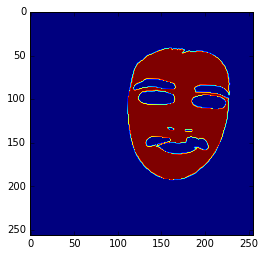

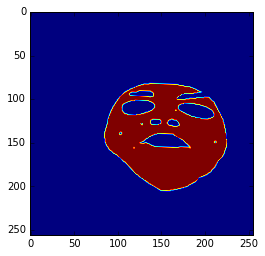

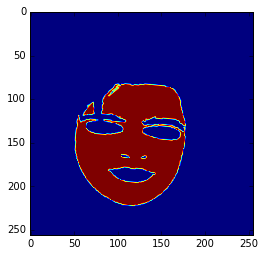

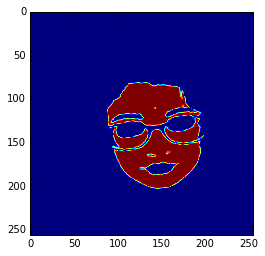

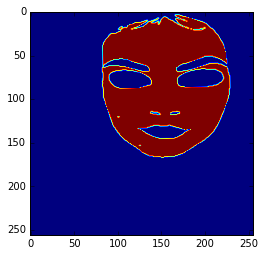

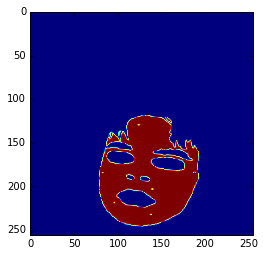

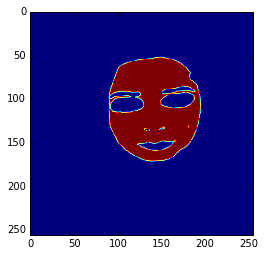

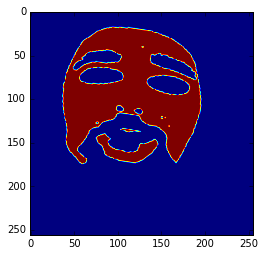

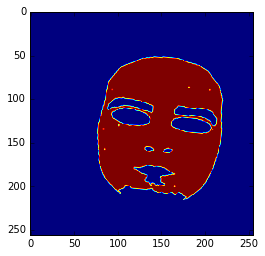

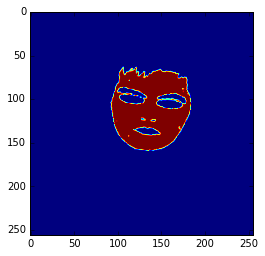

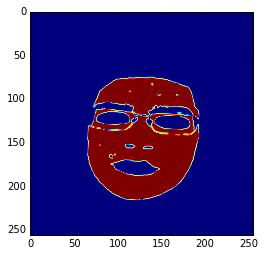

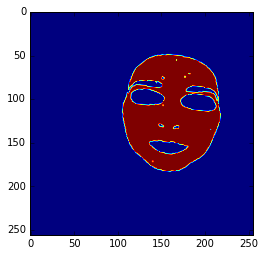

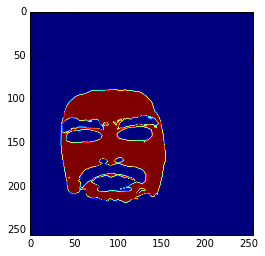

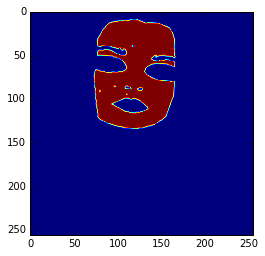

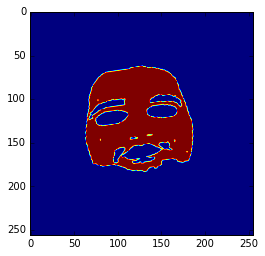

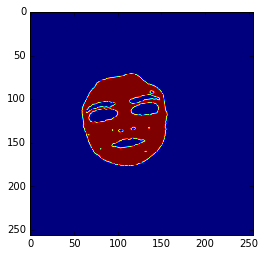

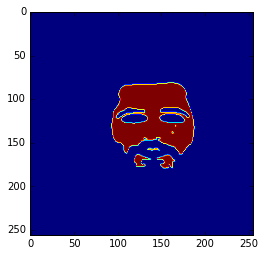

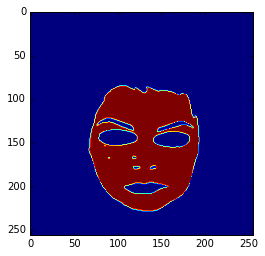

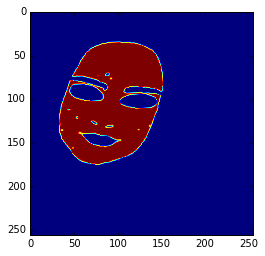

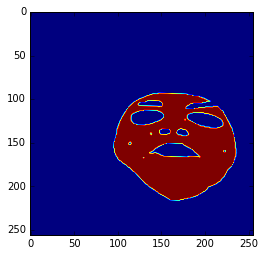

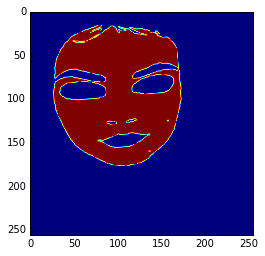

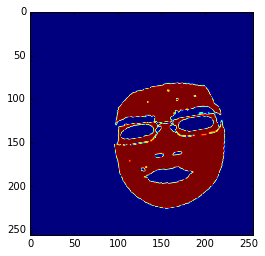

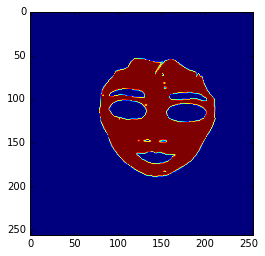

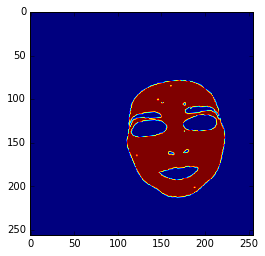

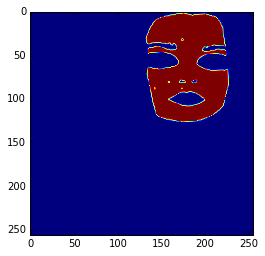

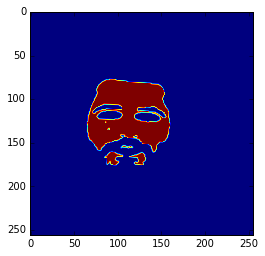

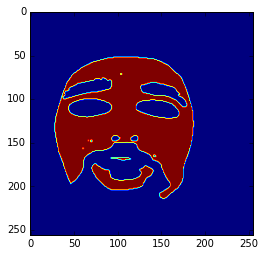

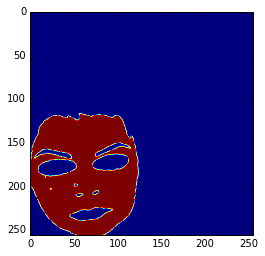

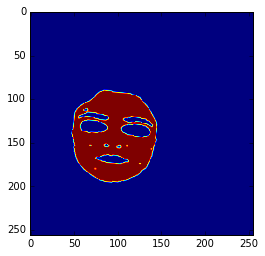

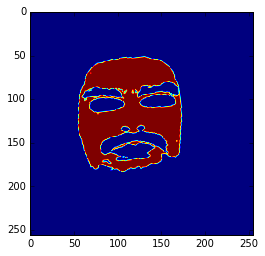

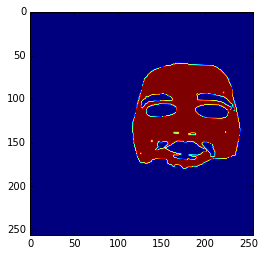

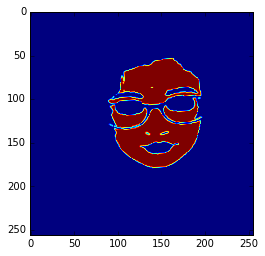

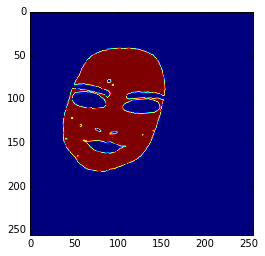

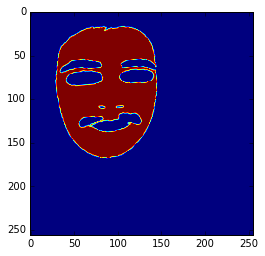

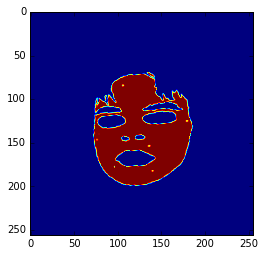

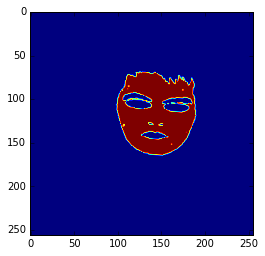

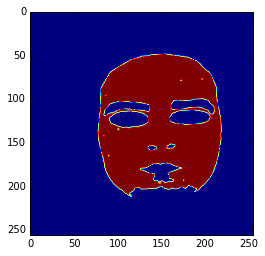

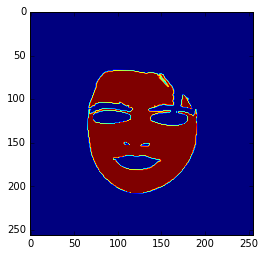

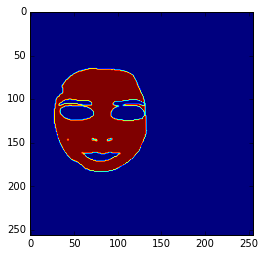

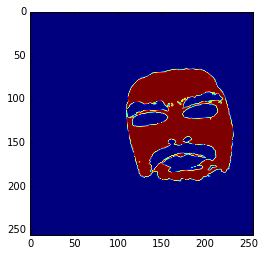

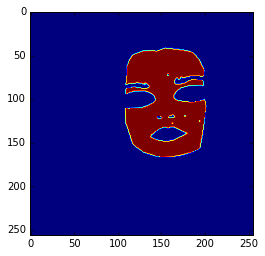

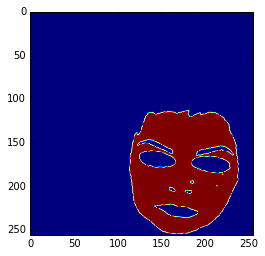

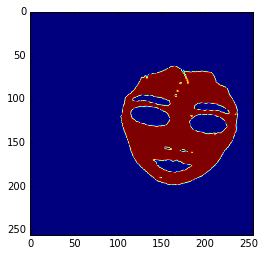

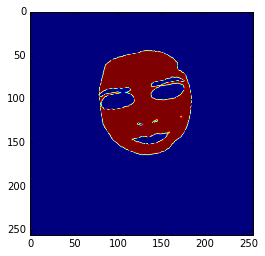

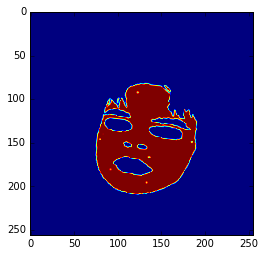

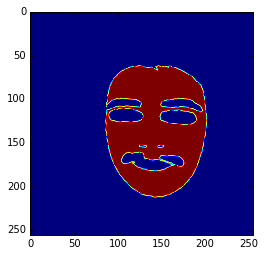

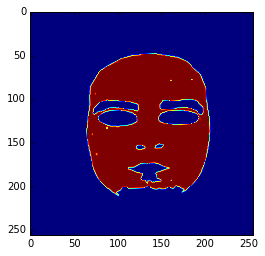

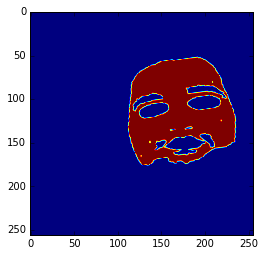

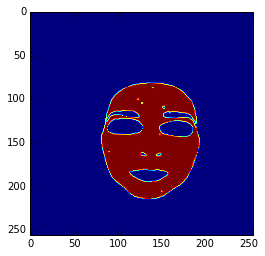

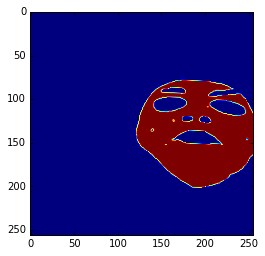

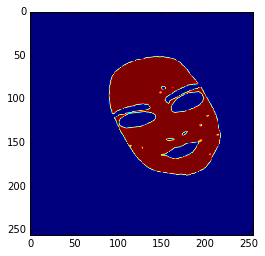

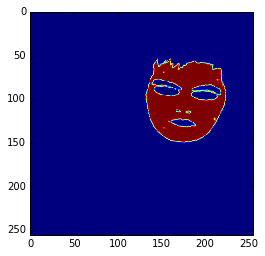

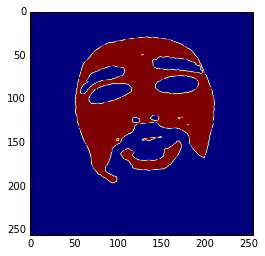

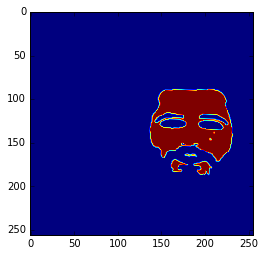

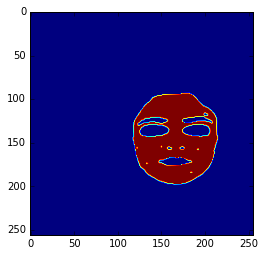

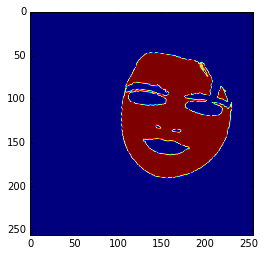

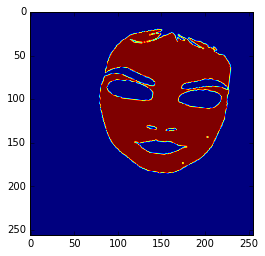

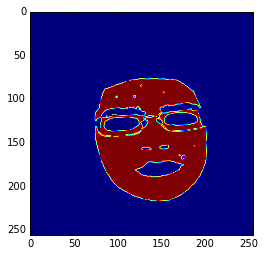

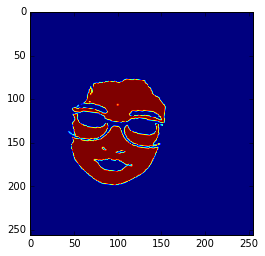

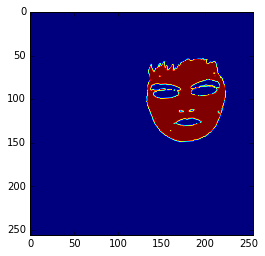

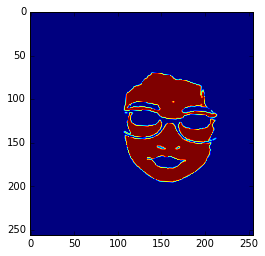

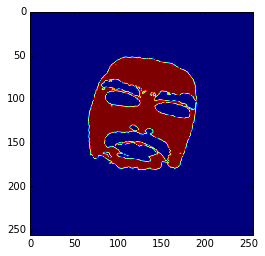

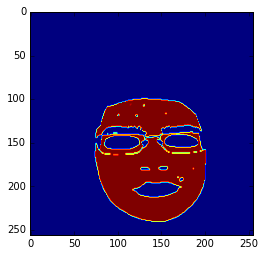

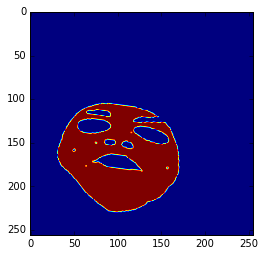

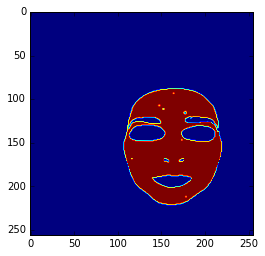

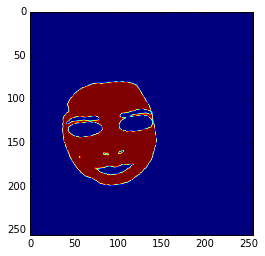

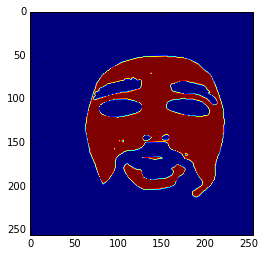

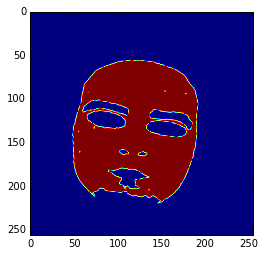

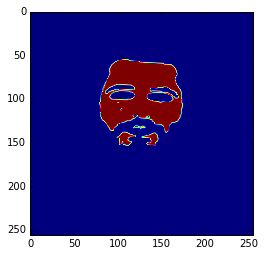

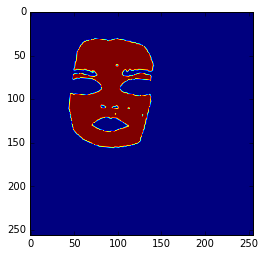

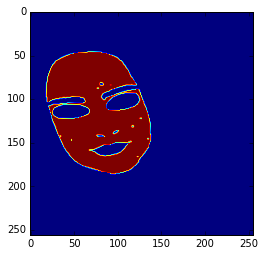

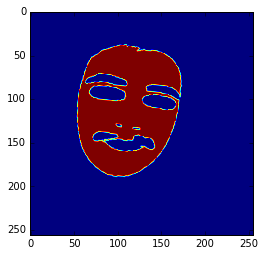

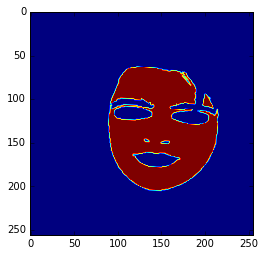

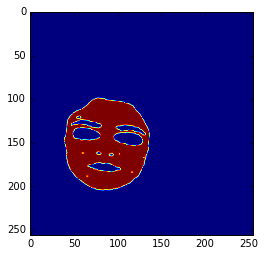

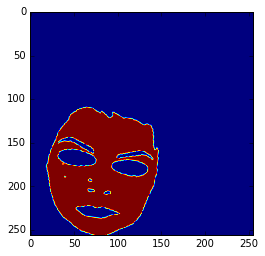

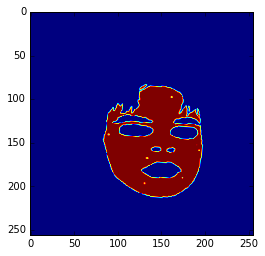

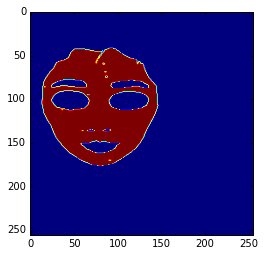

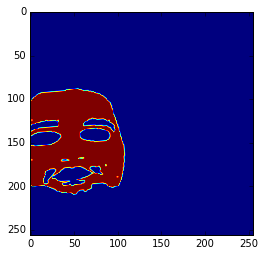

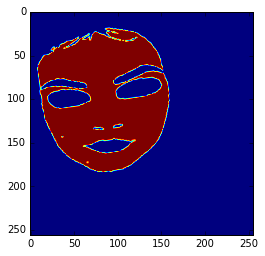

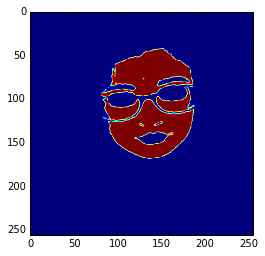

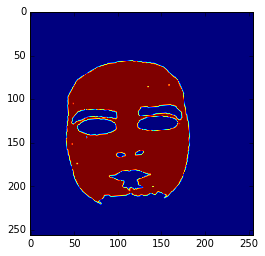

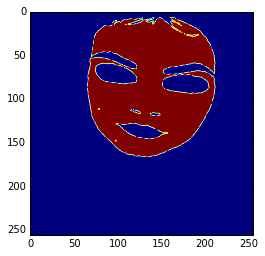

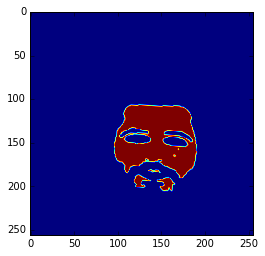

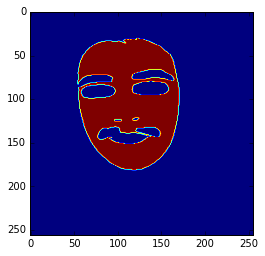

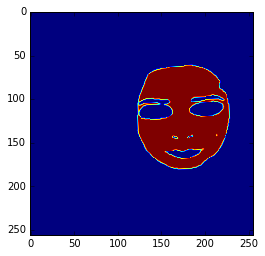

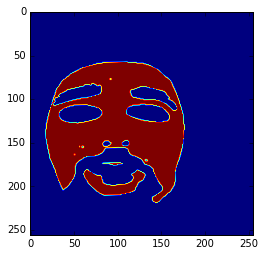

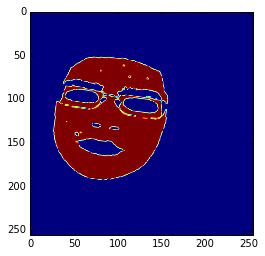

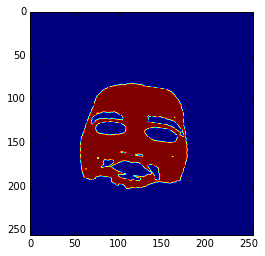

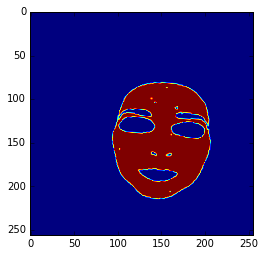

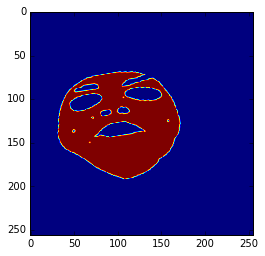

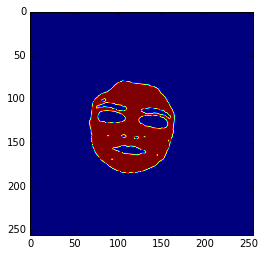

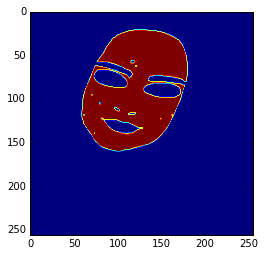

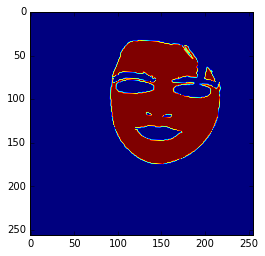

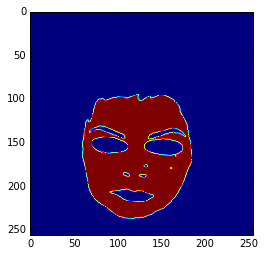

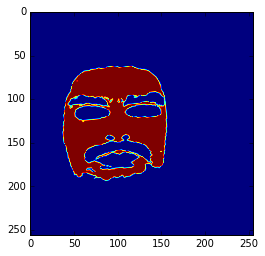

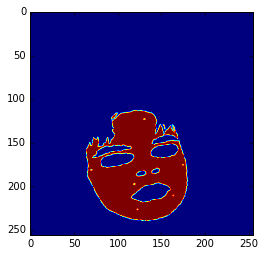

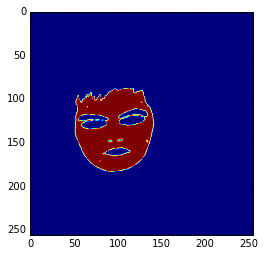

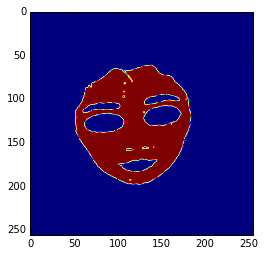

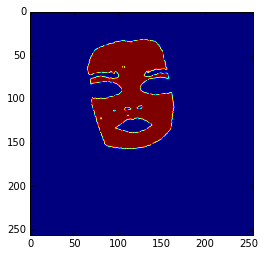

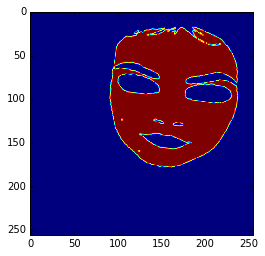

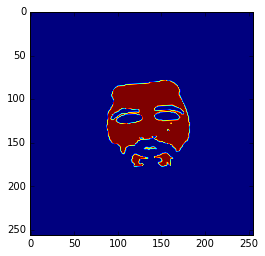

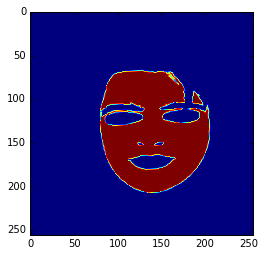

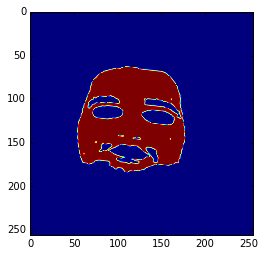

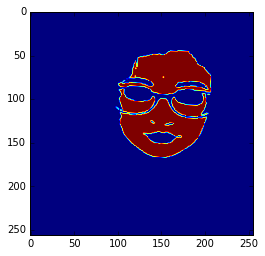

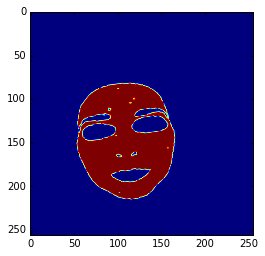

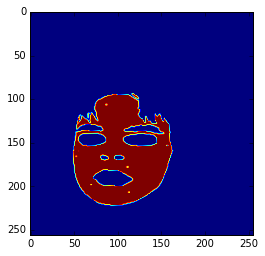

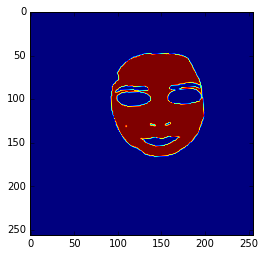

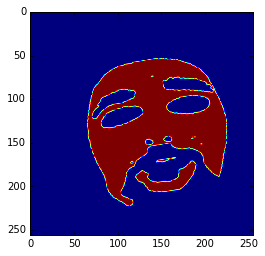

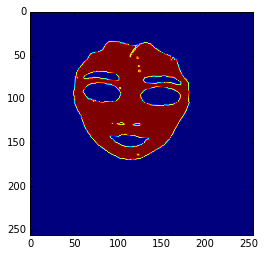

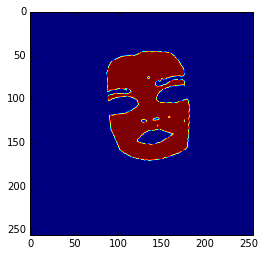

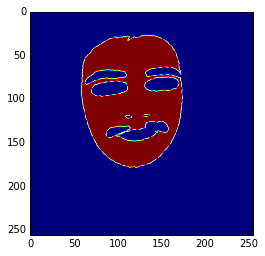

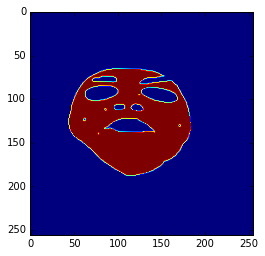

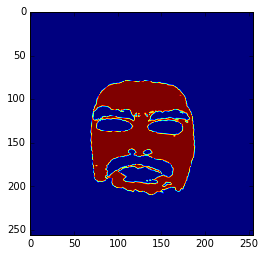

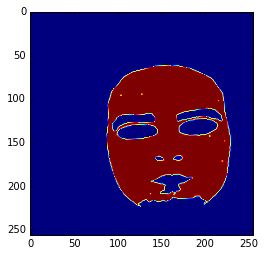

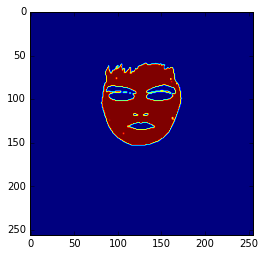

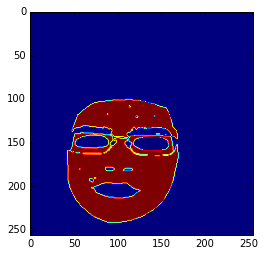

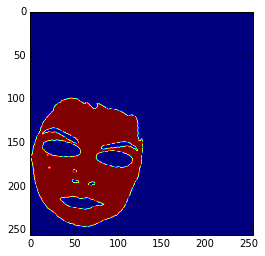

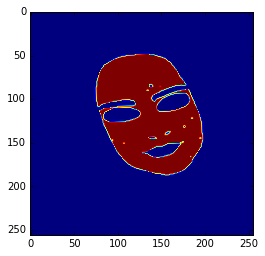

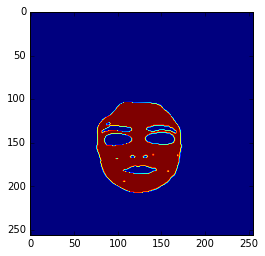

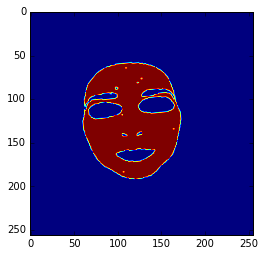

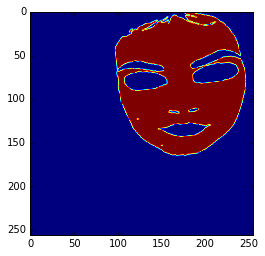

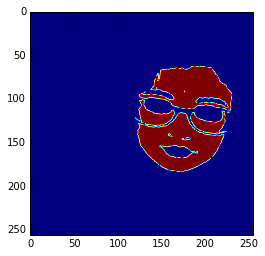

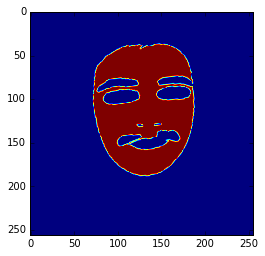

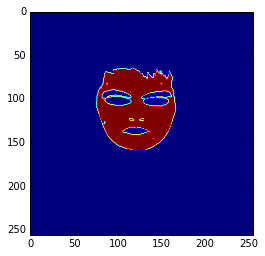

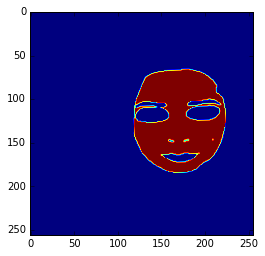

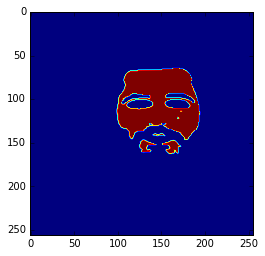

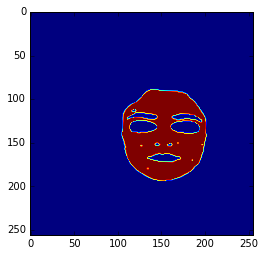

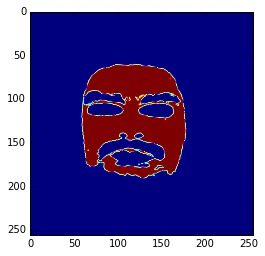

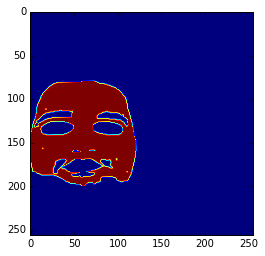

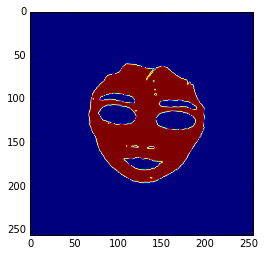

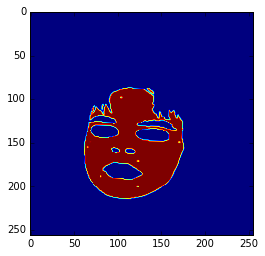

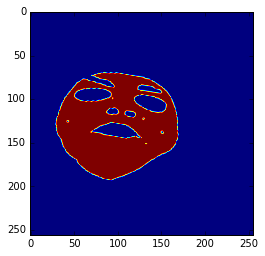

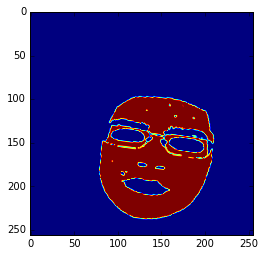

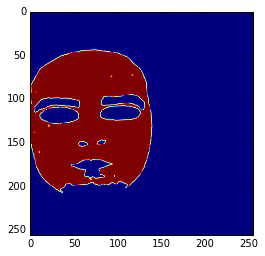

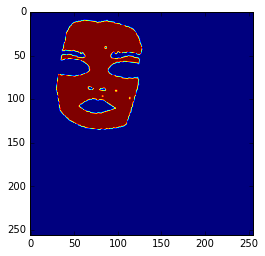

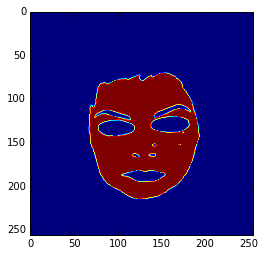

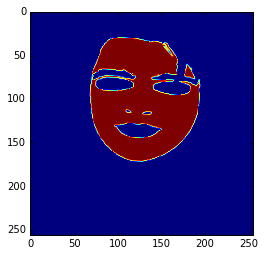

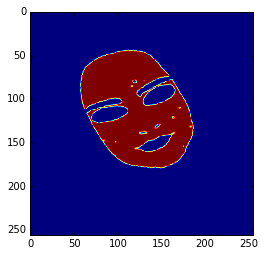

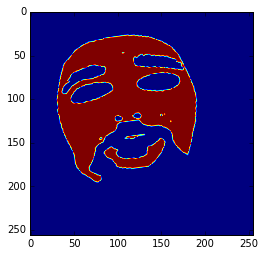

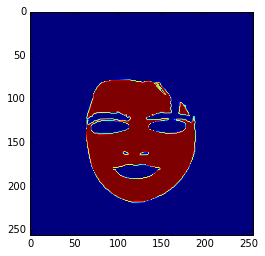

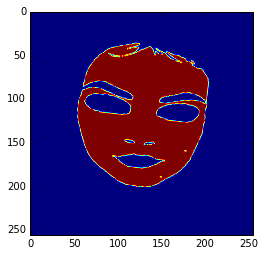

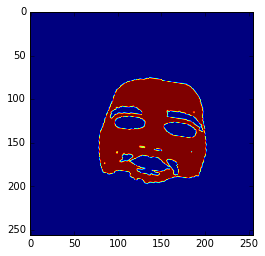

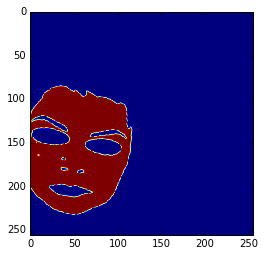

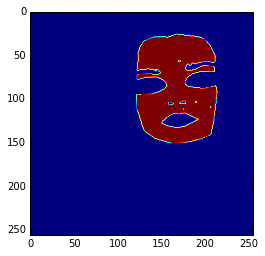

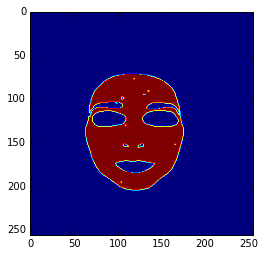

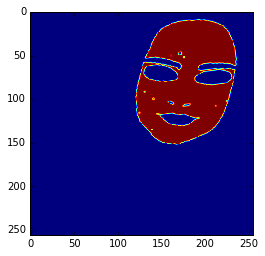

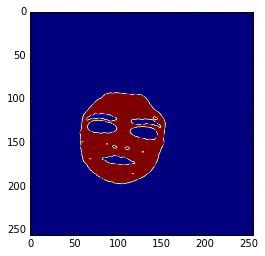

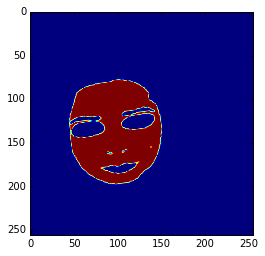

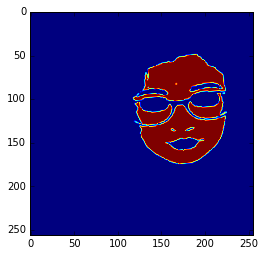

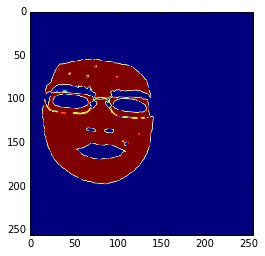

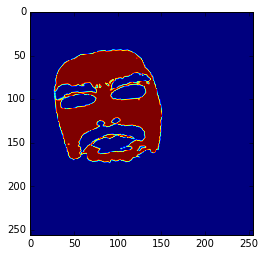

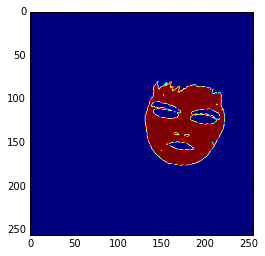

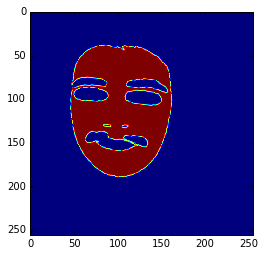

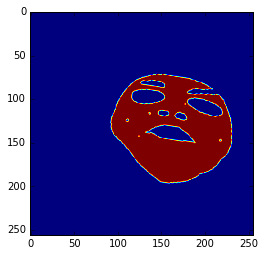

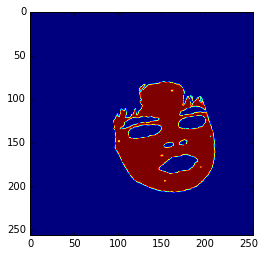

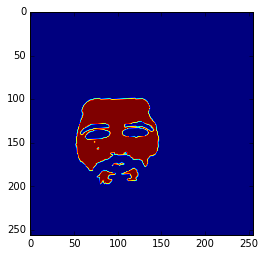

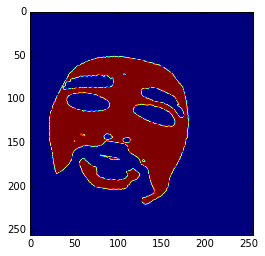

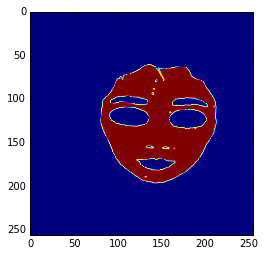

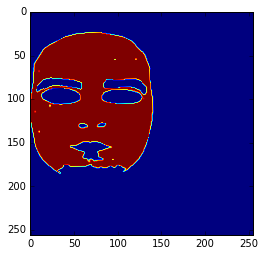

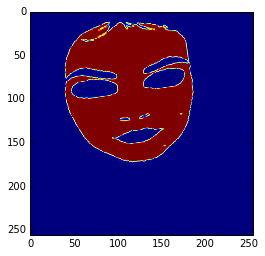

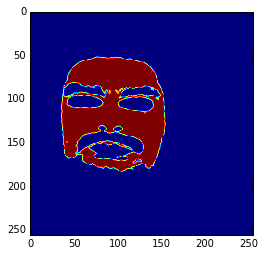

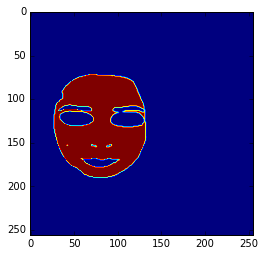

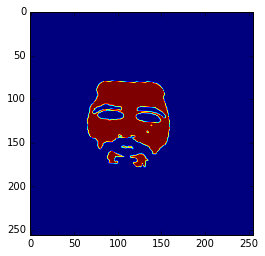

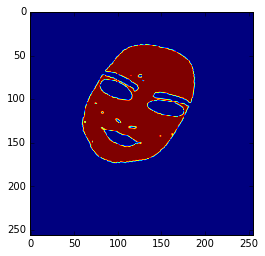

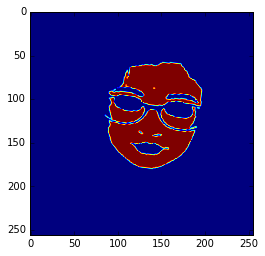

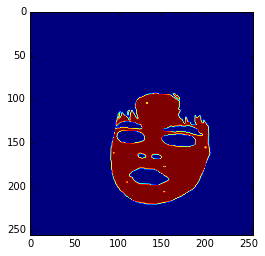

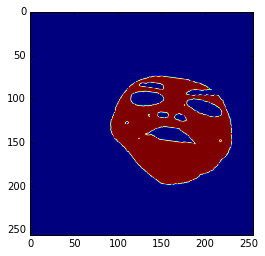

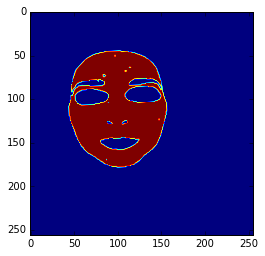

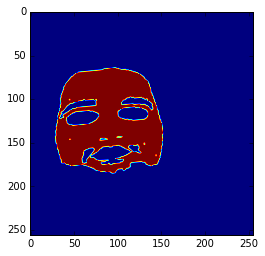

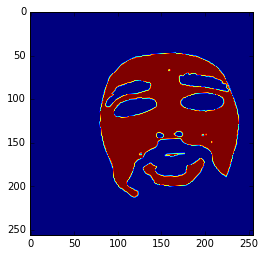

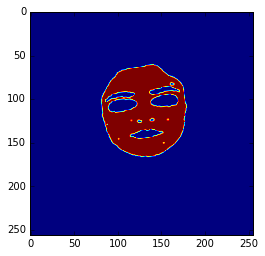

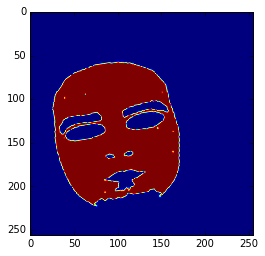

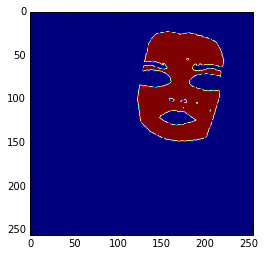

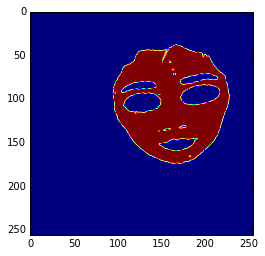

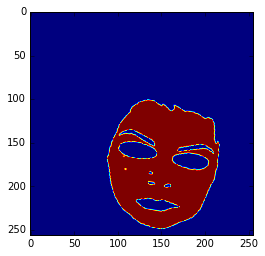

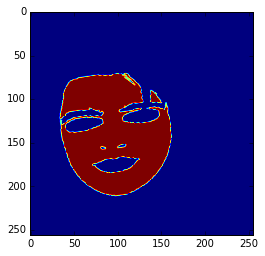

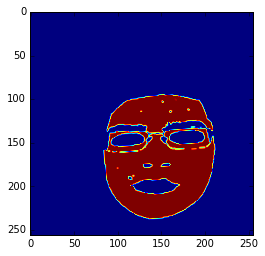

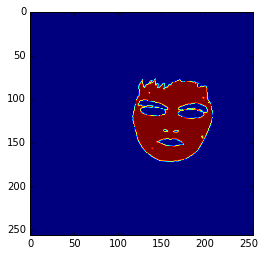

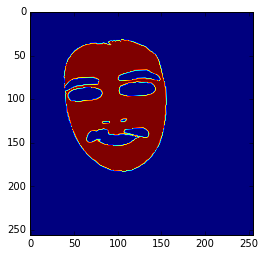

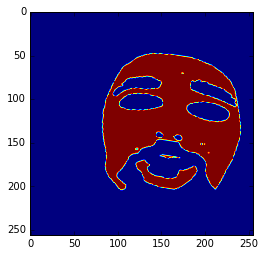

In [6]:

#augment train dataset with rotations, flips, brightness, contrast, saturation, hue
#convert images to grayscale
# Create an instance of the ImageDataGenerator class
image_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.9,1.1],
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=0.2,
    validation_split=0,
    
)
mask_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0
    
)
data_aug = image_datagen.flow(np.asarray(images), batch_size=1, shuffle=True, seed=42)
#add 4th dim to masks
masks = np.reshape(masks, (len(masks),256,256,1))
mask_aug = mask_datagen.flow(masks, batch_size=1, shuffle=True, seed=42)

index = 0
train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))
for m in mask_aug:
    plt.imshow(m[0])
    plt.show()
    index += 1
    if index > 200:
        break

In [10]:
#get length of mask_aug
print(len(list(mask_aug)))

KeyboardInterrupt: 

length of images:  20
shape of images:  (20, 256, 256, 3)


TypeError: Invalid shape (10, 256, 256, 1) for image data

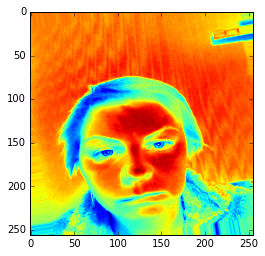

In [27]:
#augment train dataset with rotations, flips, brightness, contrast, saturation, hue
# Create an instance of the ImageDataGenerator class
image_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rescale=1./255,
    fill_mode='nearest',
    validation_split=None
    
)
mask_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rescale=1./255,
    fill_mode='nearest',
    validation_split=None
    
)
images_grey = np.reshape(images_grey, (len(images_grey), 256, 256, 1))

masks = np.reshape(masks, (len(masks), 256, 256, 1))
data_aug = image_datagen.flow(np.asarray(images_grey), batch_size=10, shuffle=True, seed=42) 

mask_aug = mask_datagen.flow(masks, batch_size=10, shuffle=True, seed=42)
print("length of images: ", len(images))
print("shape of images: ", np.asarray(images).shape)
# print(np.asarray(data_aug).shape)
index = 0
for augmented in data_aug:
    #show image next to mask
    plt.imshow(augmented[1])  
    plt.imshow(mask_aug[index])
    plt.show()
    index += 1

# train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(images), tf.data.Dataset.from_tensor_slices(masks)))
# print("length: ", len(list(data_aug)))